# GRAPE for preparing a cat state using L-BFGS Tutorial

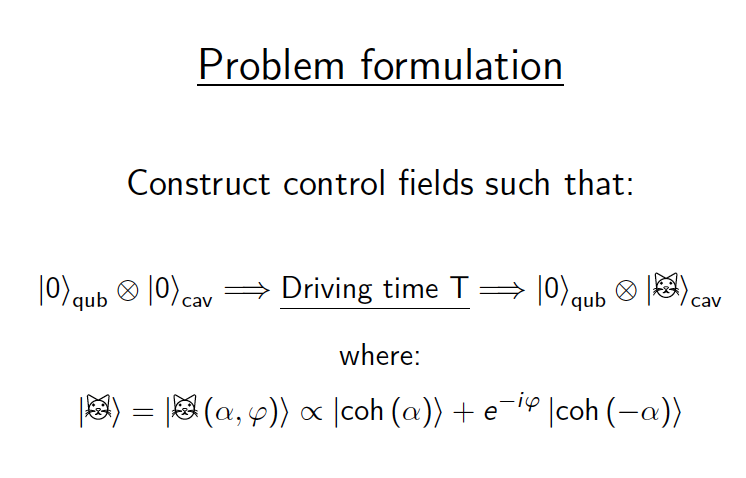

In [ ]:
# ruff: noqa
import feedback_grape.grape as fg
from feedback_grape.solver import sesolve
import jax.numpy as jnp
from feedback_grape.utils.operators import *
from feedback_grape.utils.states import basis, coherent
from feedback_grape.utils.tensor import tensor

### Step 1: initialize parameters

In [2]:
T = 1  # microsecond
num_of_intervals = 100
N = 30  # dimension of hilbert space
alpha = 1.5
# Phase for the interference
phi = jnp.pi

In [3]:
hconj = lambda a: jnp.swapaxes(a.conj(), -1, -2)

In [4]:
chi = 0.2385 * (2 * jnp.pi)
mu_qub = 4.0
mu_cav = 8.0

### Step 2: define initial and target states

In [5]:
psi0 = tensor(basis(2), basis(N))
cat_target_state = coherent(N, alpha) + jnp.exp(-1j * phi) * coherent(
    N, -alpha
)
psi_target = tensor(basis(2), cat_target_state)

### Step 3: Build the hamiltonian

In [6]:
# Using Jaynes-Cummings model for qubit + cavity
def build_grape_format_ham():
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    a = tensor(identity(2), destroy(N))
    adag = tensor(identity(2), create(N))
    n_phot = adag @ a
    sigz = tensor(sigmaz(), identity(N))
    sigp = tensor(sigmap(), identity(N))
    one = tensor(identity(2), identity(N))

    H0 = +(chi / 2) * n_phot @ (sigz + one)
    H_ctrl_qub = mu_qub * sigp
    H_ctrl_qub_dag = hconj(H_ctrl_qub)
    H_ctrl_cav = mu_cav * adag
    H_ctrl_cav_dag = hconj(H_ctrl_cav)

    H_ctrl = [H_ctrl_qub, H_ctrl_qub_dag, H_ctrl_cav, H_ctrl_cav_dag]

    return H0, H_ctrl

### Step 4: Run GRAPE

In [7]:
# Outputs Fidelity of 0.9799029117042408 but in like 30 minutes
H0, H_ctrl = build_grape_format_ham()
res = fg.optimize_pulse(
    H0,
    H_ctrl,
    psi0,
    psi_target,
    num_t_slots=num_of_intervals,
    total_evo_time=T,
    type="state",
    optimizer="l-bfgs",
)
print("Final fidelity: ", res.final_fidelity)

Final fidelity:  0.9887391119302493


### Reconstructing hamiltonian from output signals

In [8]:
def build_ham_reconstructed(u1, u2, u3, u4):
    """
    Build Hamiltonian for given (complex) e_qub and e_cav
    """

    a = tensor(identity(2), destroy(N))
    adag = tensor(identity(2), create(N))
    n_phot = adag @ a
    sigz = tensor(sigmaz(), identity(N))
    sigp = tensor(sigmap(), identity(N))
    one = tensor(identity(2), identity(N))

    H0 = +(chi / 2) * n_phot @ (sigz + one)
    H_ctrl_qub = mu_qub * sigp
    H_ctrl_qub_dag = hconj(H_ctrl_qub)
    H_ctrl_cav = mu_cav * adag
    H_ctrl_cav_dag = hconj(H_ctrl_cav)

    # Apply control amplitudes
    H_ctrl = (
        u1 * H_ctrl_qub
        + u2 * H_ctrl_qub_dag
        + u3 * H_ctrl_cav
        + u4 * H_ctrl_cav_dag
    )

    H = H0 + H_ctrl
    return H

In [9]:
u1 = res.control_amplitudes[:, 0]
u2 = res.control_amplitudes[:, 1]
u3 = res.control_amplitudes[:, 2]
u4 = res.control_amplitudes[:, 3]

In [10]:
H_total = jnp.array(
    [
        build_ham_reconstructed(u1[i], u2[i], u3[i], u4[i])
        for i in range(len(u1))
    ]
)

In [11]:
time_start = 0.0
time_end = 1.0
# Eqivalant to delta_ts = jnp.repeat(0.2, time_intervals_num).astype(jnp.float32)
# However, it is implemented in this way to be more general and
# show that these are the differences between the time intervals
t_grid = jnp.linspace(time_start, time_end, num_of_intervals + 1)
delta_ts = t_grid[1:] - t_grid[:-1]

In [ ]:
psi_fg = sesolve(H_total, psi0, delta_ts)
print(fg.fidelity(C_target=psi_target, U_final=psi_fg, type="state"))

0.9887391119221739
